In [ ]:
# data link = 'https://www.kaggle.com/datasets/nphantawee/pump-sensor-data'
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [ ]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# Load the data
train_data_url = "/content/drive/MyDrive/ECE 453 project/sensor.csv"
df = pd.read_csv(train_data_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# drop unecessary column
df = df.iloc[: , 1:] 
del df['timestamp']
df

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,15.11863,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


False


0         1
2         1
3         1
4         1
5         1
         ..
220315    1
220316    1
220317    1
220318    1
220319    1
Name: machine_status, Length: 217444, dtype: int64

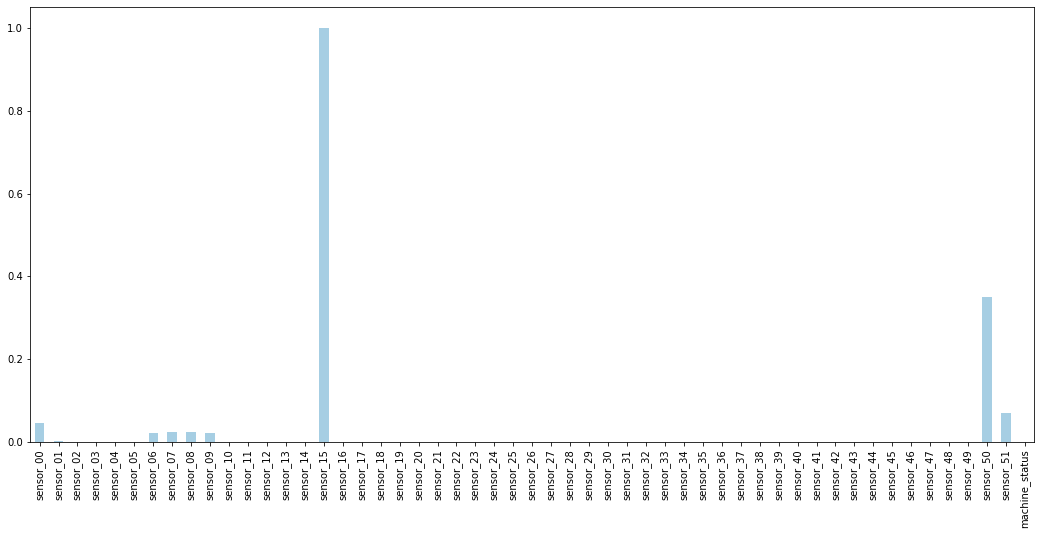

In [ ]:
# data preprocessing

# change data type ( for sensor to numeric)
for var_index in [item for item in df.columns if 'sensor_' in item]:
  df[var_index] = pd.to_numeric(df[var_index], errors = 'coerce')

# find Null
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

# since sensor 15 is all null, sensor 50 is 50% null, delete
# other sensors with null, use previous time's data for null

# delete duplicates
df = df.drop_duplicates()

# delete sensor 15, 50
del df['sensor_15']
del df['sensor_50']

# fill null for previous data
df = df.fillna(method = 'ffill')

# check if there is still nan (False = No, True = Yes)

check_for_nan = df.isnull().values.any()
print (check_for_nan)

# Change string to the number (normal = 1, others = 0)
Status = { "NORMAL": 1, "BROKEN": 0, "RECOVERING":0}
state = df["machine_status"].replace(Status)
df['machine_status']=state

df['machine_status']

In [ ]:
# split x, y
input_x = df.drop('machine_status', axis=1).values
input_y = df['machine_status'].values

n_features = input_x.shape[1]

# LSTM needs 3dim data shape, change it to 3 dim using timestep

def temporalize(X, y, timesteps):
	output_X = []
	output_y = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
		output_y.append(y[i + timesteps + 1])
	return np.squeeze(np.array(output_X)), np.array(output_y)

In [ ]:
# define timestep as 5 min
timesteps = 5
# Temporalize
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape) 

# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

print('length of x_train : ',len(x_train))  
print('length of x_valid : ',len(x_valid))  
print('length of x_test : ',len(x_test))   

# For training the autoencoder, split 0 / 1
# use only normal data for training
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]
print(x_train_y0.shape)


(217438, 5, 50)
length of x_train :  139160
length of x_valid :  34790
length of x_test :  43488
(9113, 5, 50)


In [ ]:
# Use flatten since scaler needs 2D
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

# Standardization for different data characteristics
scaler = StandardScaler().fit(flatten(x_train_y1))

x_train_y1_scaled = scale(x_train_y1, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y1_scaled = scale(x_valid_y1, scaler)
x_test_scaled = scale(x_test, scaler)

# define parameters
epochs = 200
batch = 128
lr = 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             10624     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 5, 16)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 5, 32)             6272      
                                                                 
 time_distributed (TimeDistr  (None, 5, 50)            1650      
 ibuted)                                                

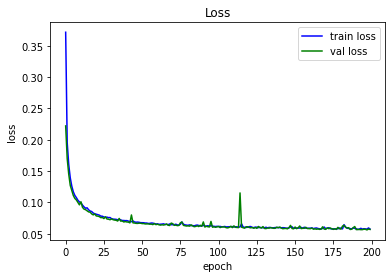

---Predicted---
[[[ 2.440e-01  6.380e-01  1.385e+00 ...  9.770e-01  2.600e-02 -1.600e-02]
  [ 1.550e-01  4.700e-01  1.294e+00 ...  1.017e+00  2.000e-03 -5.000e-03]
  [ 1.450e-01  3.930e-01  1.254e+00 ...  1.075e+00  9.600e-02 -7.600e-02]
  [ 1.000e-01  3.280e-01  1.273e+00 ...  1.081e+00  8.100e-02 -1.180e-01]
  [ 8.500e-02  2.740e-01  1.275e+00 ...  1.113e+00  1.220e-01 -1.710e-01]]

 [[ 2.500e-01 -7.390e-01  1.110e-01 ... -7.480e-01 -6.650e-01 -3.600e-01]
  [ 1.860e-01 -7.780e-01  4.700e-02 ... -7.680e-01 -7.420e-01 -3.240e-01]
  [ 1.740e-01 -7.960e-01  4.200e-02 ... -7.650e-01 -7.610e-01 -3.330e-01]
  [ 1.720e-01 -7.850e-01  6.000e-02 ... -7.470e-01 -7.570e-01 -3.390e-01]
  [ 1.740e-01 -7.770e-01  7.100e-02 ... -7.430e-01 -7.620e-01 -3.440e-01]]

 [[ 1.860e-01  1.549e+00  5.750e-01 ...  2.249e+00  3.145e+00 -5.600e-02]
  [ 2.910e-01  1.623e+00  7.350e-01 ...  2.054e+00  3.247e+00  3.000e-02]
  [ 2.720e-01  1.626e+00  7.550e-01 ...  2.071e+00  3.188e+00  1.800e-02]
  [ 2.700e-01  1.6

In [ ]:
 # define model
lstm_ae = keras.models.Sequential()
# Encoder
lstm_ae.add(keras.layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(keras.layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(keras.layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(keras.layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(keras.layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(keras.layers.TimeDistributed(keras.layers.Dense(n_features)))

lstm_ae.summary()

# compile
lstm_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train_y1_scaled, x_train_y1_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y1_scaled, x_valid_y1_scaled))
# plot result
plt.plot(history.history['loss'], 'b', label='train loss')
plt.plot(history.history['val_loss'], 'g', label='val loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

# demonstrate reconstruction
x_predict = lstm_ae.predict(x_test_scaled, verbose=0)
print('---Predicted---')
print(np.round(x_predict,3))
print('---Actual---')
print(np.round(x_test_scaled, 3))